In [33]:
from __future__ import print_function, division
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay,precision_recall_curve,PrecisionRecallDisplay,roc_curve,RocCurveDisplay
import time
import os
import copy


cudnn.benchmark = True
plt.ion()   # interactive mode|
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_path = '../dataset/training'
test_path = '../dataset/test'
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
train_data = datasets.ImageFolder(root=train_path, transform=transformations)
test_data = datasets.ImageFolder(root=test_path, transform=transformations)
classes =['bird','cat']

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

In [5]:
# obtain training indices that will be used for validation
num_train = len(train_data)
train_index= list(range(num_train))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

C:\Users\Allen\AppData\Local\Temp\ipykernel_5488\409411250.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2318.)
  plt.imshow(img.T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


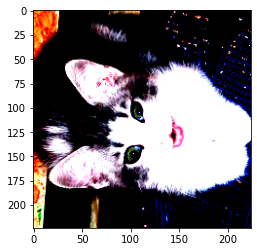

Label: 1


In [6]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T)
plt.show()
print(f"Label: {label}")

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"\nBest validation loss: {best_acc}")
                print(f"\nSaving best model for epoch: {epoch}\n")
                torch.save({
                'epoch': epoch,
                'model_state_dict': model_ft.state_dict(),
                'optimizer_state_dict': optimizer_ft.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def test (classes, model, test_loader, criterion):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    model.eval() # prep model for evaluation

    for data, target in test_loader:

        data = data.to(device)
        output = model(data).to("cpu")
        loss = criterion(output, target)
        test_loss += loss.item()*data.size(0)

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
          
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    test_acc = 100. * np.sum(class_correct) / np.sum(class_total)

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        test_acc,
        np.sum(class_correct), np.sum(class_total)))

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
dataloaders = {'train':train_loader,'val':test_loader}
dataset_sizes = {'train':len(train_data),'val':len(test_data)}

In [11]:
from torchsummary import summary
summary(model_ft,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.0362 Acc: 0.9881
val Loss: 0.0498 Acc: 0.9758

Best validation loss: 0.9757575757575757

Saving best model for epoch: 0


Training complete in 1m 55s
Best val Acc: 0.975758


In [13]:
# checkpoint  = torch.load('best_model.pth', map_location=torch.device('cpu'))
# model_ft = torch.nn.DataParallel(model_ft)
# model_ft.load_state_dict(checkpoint, strict=False)

In [14]:
def get_result(model,test_loader):
    y_test = []
    y_pred = []
    for data, target in test_loader:
        data = data.to(device)
        output = model(data).to("cpu")
        _, pred = torch.max(output, 1)
        pred = pred.data.numpy()
        target = target.data.numpy()
        y_pred.append(pred.flatten()[:])
        y_test.append(target.flatten()[:])
    y_test = np.concatenate(y_test)
    y_pred = np.concatenate(y_pred)
    return y_test, y_pred

In [15]:
test(classes, model_ft, test_loader, criterion)

Test Accuracy of  bird: 96% (79/82)
Test Accuracy of   cat: 97% (243/248)
Test Loss: 0.049777


Test Accuracy (Overall): 97% (322/330)


In [16]:
y_test, y_pred = get_result(model_ft, test_loader)

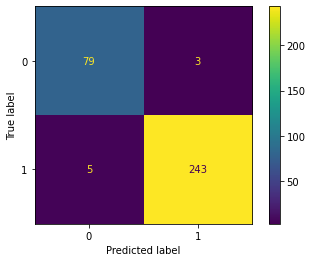

In [23]:
confusion_matrix=metrics.confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix).plot()

In [18]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9716266719118805

Text(0.5, 0, 'False Positive Rate')

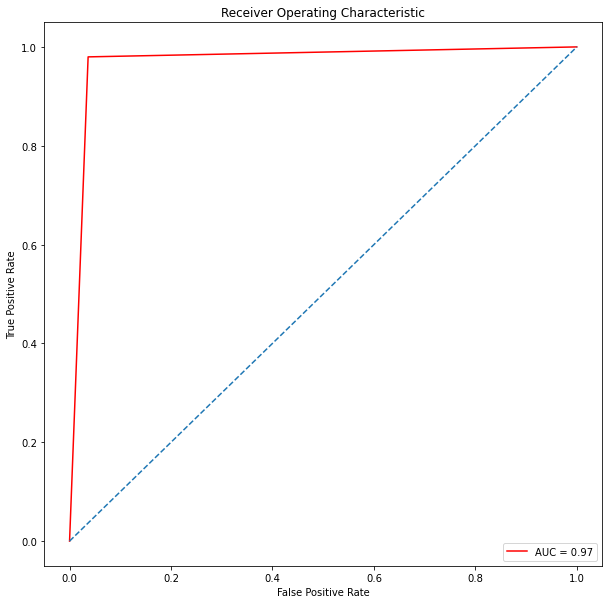

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [37]:
fpr, tpr, _ = roc_curve(y_test, y_pred, 1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

d:\Anaconda\envs\ml\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [38]:
prec, recall, _ = precision_recall_curve(y_test, y_pred,1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

d:\Anaconda\envs\ml\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass pos_label=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


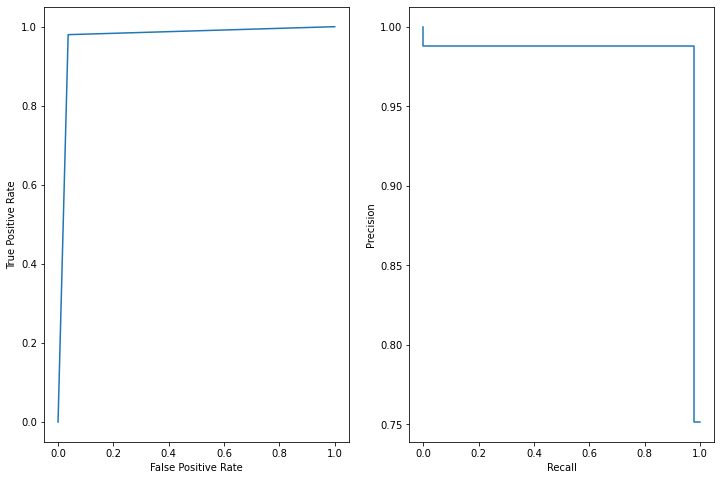

In [39]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()